# imports

In [38]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import datetime

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(style="darkgrid")



from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid

In [2]:
co2_df = pd.read_csv('data/co2_concentration_df.csv')

In [4]:
co2_df['datetime'] = co2_df['datetime'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
co2_df.set_index('datetime', inplace=True)

## treating data

In [14]:
co2_diff = pd.DataFrame(co2_df['data_mean_global'].diff(1))

In [15]:
co2_diff.dropna(inplace=True)

In [16]:
co2_diff

data_mean_global
datetime                    
1677-11-15          1.004565
1677-12-15          0.637296
1678-01-15          0.460474
1678-02-15          0.383064
1678-03-15          0.341987
...                      ...
2014-08-15         -1.075374
2014-09-15          0.453349
2014-10-15          1.641950
2014-11-15          1.520315
2014-12-15          0.990618

[4046 rows x 1 columns]

In [17]:
co2_diff['data_mean_global'].plot(kind='kde')

In [18]:
s_decomp = seasonal_decompose(co2_diff['data_mean_global'], model='additive', period=12)
s_decomp.plot()
plt.show()

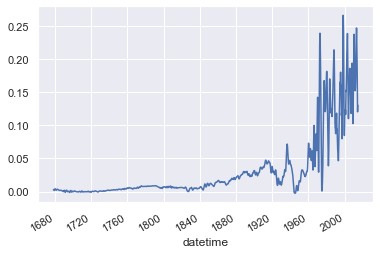

In [20]:
s_decomp.trend.plot()



In [19]:
fig, ax = plt.subplots(figsize=(20,10))

ax = plot_acf(co2_diff['data_mean_global'], ax, title='CO2 Concentration 1st Difference Autocorrelation')

plt.show()

## creating lagged DF

In [21]:
lagged_df = pd.DataFrame()

In [22]:
for i in range(12, 0, -1):
    lagged_df[['t-' + str(i)]] = co2_diff.shift(i)

lagged_df['t'] = co2_diff['data_mean_global']

In [23]:
lagged_df

t-12      t-11      t-10       t-9       t-8       t-7  \
datetime                                                                 
1677-11-15       NaN       NaN       NaN       NaN       NaN       NaN   
1677-12-15       NaN       NaN       NaN       NaN       NaN       NaN   
1678-01-15       NaN       NaN       NaN       NaN       NaN       NaN   
1678-02-15       NaN       NaN       NaN       NaN       NaN       NaN   
1678-03-15       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2014-08-15 -1.054752  0.459491  1.601446  1.466388  0.933017  0.820863   
2014-09-15  0.459491  1.601446  1.466388  0.933017  0.820863  0.380413   
2014-10-15  1.601446  1.466388  0.933017  0.820863  0.380413  0.229407   
2014-11-15  1.466388  0.933017  0.820863  0.380413  0.229407  0.074560   
2014-12-15  0.933017  0.820863  0.380413  0.229407  0.074560 -0.470685   

                 t-6       t-5       t-4       t-3       t-2       t-1  \
datetime                                                                 
1677-11-15       NaN       NaN       NaN       NaN       NaN       NaN   
1677-12-15       NaN       NaN       NaN       NaN       NaN  1.004565   
1678-01-15       NaN       NaN       NaN       NaN  1.004565  0.637296   
1678-02-15       NaN       NaN       NaN  1.004565  0.637296  0.460474   
1678-03-15       NaN       NaN  1.004565  0.637296  0.460474  0.383064   
...              ...       ...       ...       ...       ...       ...   
2014-08-15  0.380413  0.229407  0.074560 -0.470685 -1.286312 -1.688781   
2014-09-15  0.229407  0.074560 -0.470685 -1.286312 -1.688781 -1.075374   
2014-10-15  0.074560 -0.470685 -1.286312 -1.688781 -1.075374  0.453349   
2014-11-15 -0.470685 -1.286312 -1.688781 -1.075374  0.453349  1.641950   
2014-12-15 -1.286312 -1.688781 -1.075374  0.453349  1.641950  1.520315   

                   t  
datetime              
1677-11-15  1.004565  
1677-12-15  0.637296  
1678-01-15  0.460474  
1678-02-15  0.383064  
1678-03-15  0.341987  
...              ...  
2014-08-15 -1.075374  
2014-09-15  0.453349  
2014-10-15  1.641950  
2014-11-15  1.520315  
2014-12-15  0.990618  

[4046 rows x 13 columns]

In [24]:
lagged_df.dropna(axis=0, inplace=True)

### features and target

In [25]:
X = lagged_df.iloc[:, :-1].values
y = lagged_df.iloc[:, -1:].values

In [26]:
train_size = int(len(X) * 0.8)

In [27]:
X_train, X_test, y_train, y_test = X[0:train_size], X[train_size:len(X)], y[0:train_size], y[train_size:len(X)]

print('train size ' +str(len(X_train) ))
print('test size ' +str(len(X_test) ))

train size 3227
test size 807


## Decicion Tree

does not work well with data w trend

In [34]:
global_temp_tree = DecisionTreeRegressor(max_depth= 4)
global_temp_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [35]:
global_temp_tree.score(X_train, y_train)

0.9988456044763335

In [36]:
global_temp_tree.score(X_test, y_test)

0.7562096808350521

In [37]:
plt.subplots(figsize=(10,10))
train_prediction = global_temp_tree.predict(X_train)
test_prediction = global_temp_tree.predict(X_test)
plt.scatter(y_train, train_prediction, label='train')
plt.scatter(y_test, test_prediction, label='test')
plt.legend()
plt.show()

## Random Forest

In [39]:
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=200)

In [40]:
rfr.score(X_train, y_train)

0.9999981823463513

In [41]:
rfr.score(X_test, y_test)

0.9113993020208099

### grid search

In [42]:
grid = {'n_estimators': [50, 100, 200], 'max_depth': {3, 5, 7}, 'max_features': [2,3,4,5,6,7,8,9,10,11,12], 'random_state': [42]}
test_scores = []

In [43]:
for g in ParameterGrid(grid):
    rfr.set_params(**g)
    rfr.fit(X_train, y_train.ravel())
    test_scores.append(rfr.score(X_test, y_test))

In [44]:
best_score_index = np.argmax(test_scores)
best_score_index

70

In [45]:
index = 0
best_grid = dict()
for g in ParameterGrid(grid):
    if(best_score_index == index):
        print(g)
        best_grid = g
    index = index + 1



{'max_depth': 7, 'max_features': 3, 'n_estimators': 100, 'random_state': 42}


In [46]:
print(test_scores[best_score_index], best_grid)

0.9327267907290069 {'max_depth': 7, 'max_features': 3, 'n_estimators': 100, 'random_state': 42}


In [47]:
rfr.set_params(**best_grid)
rfr.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=7, max_features=3, random_state=42)

In [48]:
plt.subplots(figsize=(10,10))

train_prediction = rfr.predict(X_train)
test_prediction = rfr.predict(X_test)
plt.scatter(y_train, train_prediction, label='train')
plt.scatter(y_test, test_prediction, label='test')
plt.legend()
plt.show()

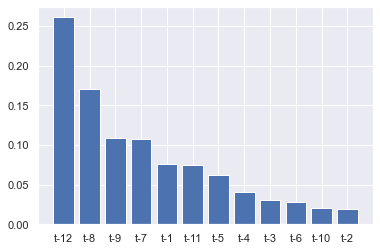

In [49]:
importances = rfr.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

names = ['t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1']
labels = np.array(names)[sorted_index]

plt.bar(x, importances[sorted_index], tick_label=labels)

plt.show()